# Evaluate AE vs VAE
- Reconstruction capabilities
- Interpolation quality and diversity
- Visualisation of representation embedding

In [2]:
import os
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import defaultdict


import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset


from my_utils import set_torch_seed

In [3]:
train_ds = MNIST(os.environ.get("MS_DATASETS_PATH"), train=True, transform=transforms.ToTensor())
train_ds = next(iter(DataLoader(train_ds, batch_size=len(train_ds), shuffle=False)))
train_ds = TensorDataset(train_ds[0].cuda(), train_ds[1].cuda())

test_ds = MNIST(os.environ.get("MS_DATASETS_PATH"), train=False, transform=transforms.ToTensor())
test_ds = next(iter(DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)))
test_ds = TensorDataset(test_ds[0].cuda(), test_ds[1].cuda())

In [4]:
def interpolate(model, index1, index2):
    """
    https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
    """
    x1 = train_ds[index1][0].cpu()
    x2 = train_ds[index2][0].cpu()
    x = torch.stack([x1,x2])
    embedding = model.embed(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image

    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.generate(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])
    
def vis_embedding(model):
    test_X, test_y = test_ds[::10]
    embd = model.embed(test_X.cpu()).view(len(test_X), -1)
    embd = TSNE().fit_transform(embd)
    
    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(embd[:, 0], embd[:, 1], c=test_y.cpu().numpy(), cmap="Set1")
    plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
    plt.show()

def report(model, logs):
    plt.plot(logs["test_recon_loss"], label="test_recon_loss")
    plt.plot(logs["test_kl_loss"], label="test_kl_loss")
    plt.legend()
    plt.show()

    interpolate(model, 0, 1)

    vis_embedding(model)

# Autoencoder
- reconstruction works quite well, interpolation less believable
- well separated clusters in representation space

In [5]:
class Autoencoder(nn.Module):
    """
    https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
    """
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def embed(self, x):
        return self.encoder(x).detach()
    
    def generate(self, x):
        return self.decoder(x).detach()
    
def train_AE(n_epochs=20, batch_size=64, lr=1e-3, seed=0):
    set_torch_seed(seed)
    criterion = nn.MSELoss()
    model = Autoencoder().cuda()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    logs = defaultdict(list)
    
    pbar = tqdm.tqdm(range(n_epochs))
    for epoch in pbar:
        for batch_X, _ in train_loader:
            out = model(batch_X)
            loss = criterion(out, batch_X)
            
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            
        test_X = test_ds.tensors[0]
        out = model(test_X)
        error = criterion(out, test_X).detach().cpu()
        logs["test"].append(error)
        pbar.set_description("Test Reconstruction Error: {:.4f}".format(error))
    
    return model.cpu(), logs

In [5]:
model_AE, logs_AE = train_AE()

Test Reconstruction Error: 0.0025: 100%|██████████| 20/20 [02:35<00:00,  7.77s/it]


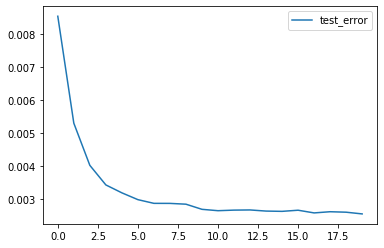

In [6]:
plt.plot(logs_AE["test"], label="test_error")
plt.legend()
plt.show()

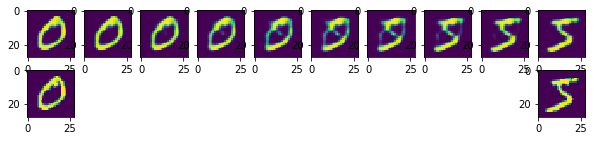

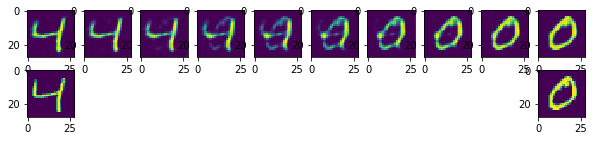

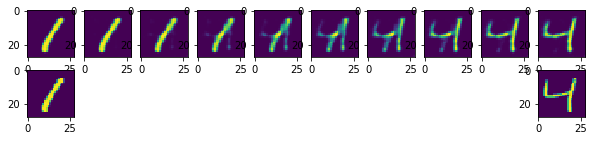

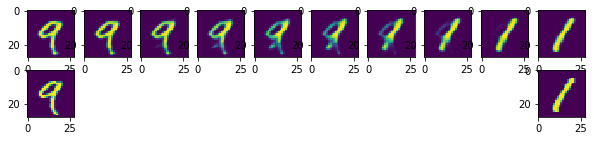

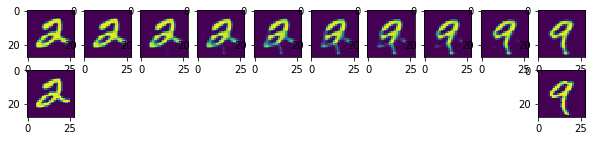

In [7]:
interpolate(model_AE, 0, 1)
interpolate(model_AE, 1, 2)
interpolate(model_AE, 2, 3)
interpolate(model_AE, 3, 4)
interpolate(model_AE, 4, 5)

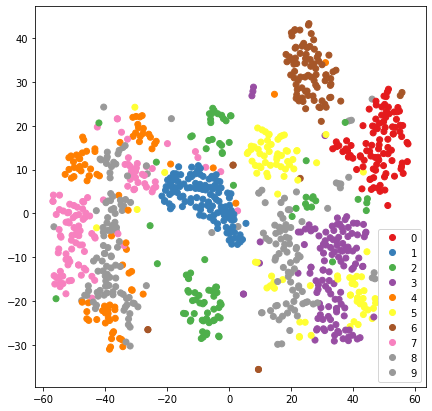

In [8]:
vis_embedding(model_AE)

# Variational Autoencoder
- Picking the right kl weight is not easy
- Interpolating works well as it produces a valid space, where one can find valid samples of different classes between the ones we are tryting to interpolate from

In [9]:
class VAE(Autoencoder):
    
    def __init__(self):
        super().__init__()
        self.latent_mean = nn.Linear(64, 10)
        self.latent_log_var = nn.Linear(64, 10)
        self.decoder_input = nn.Linear(10, 64)
        
    def sample(self, means, stds):
        eps = torch.randn_like(means).to(means.device)
        samples = eps * stds + means
        return samples
    
    def forward(self, X):
        enc = torch.relu(self.encoder(X).view(len(X), -1))
        means = self.latent_mean(enc)
        log_vars = self.latent_log_var(enc)
        repr_ = self.sample(means, (0.5 * log_vars).exp())
        rec = torch.relu(self.decoder_input(repr_)).view(len(X), 64, 1, 1)
        rec = self.decoder(rec)
        return rec, means, log_vars
    
    def embed(self, X):
        enc = torch.relu(self.encoder(X).view(len(X), -1))
        means = self.latent_mean(enc)
        log_vars = self.latent_log_var(enc)
        repr_ = self.sample(means, (0.5 * log_vars).exp())
        return repr_.detach()
    
    def generate(self, X):
        rec = torch.relu(self.decoder_input(X)).view(len(X), 64, 1, 1)
        rec = self.decoder(rec)
        return rec.detach()
    
    
def train_VAE(kl_weight=1, n_epochs=20, batch_size=64, lr=1e-3, seed=0):
    set_torch_seed(seed)
    criterion = nn.MSELoss()
    model = VAE().cuda()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    logs = defaultdict(list)
    get_kl_loss = lambda means, log_vars: kl_weight * -0.5 * (1 + log_vars - means**2 - log_vars.exp()).sum(dim=1).mean()
    
    pbar = tqdm.tqdm(range(n_epochs))
    for epoch in pbar:
        for batch_X, _ in train_loader:
            out, means, log_vars = model(batch_X)
            recon_loss = criterion(out, batch_X)
            kl_loss = get_kl_loss(means, log_vars)
            loss = recon_loss + kl_loss
            
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            
        test_X = test_ds.tensors[0]
        out, means, log_vars = model(test_X)
        recon_loss = criterion(out, test_X).detach().cpu()
        kl_loss = get_kl_loss(means, log_vars).detach().cpu()
        logs["test_recon_loss"].append(recon_loss)
        logs["test_kl_loss"].append(kl_loss)
        pbar.set_description("Test Reconstruction Error: {:.4f}".format(recon_loss))
    
    return model.cpu(), logs

## VAE kl weight 1e0
- Doesnt work at all

Test Reconstruction Error: 0.0675: 100%|██████████| 20/20 [03:12<00:00,  9.65s/it]


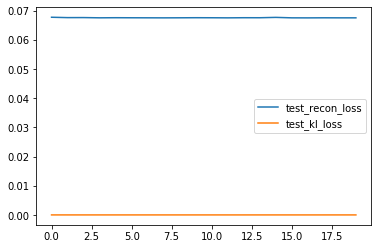

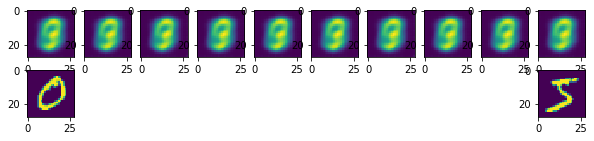

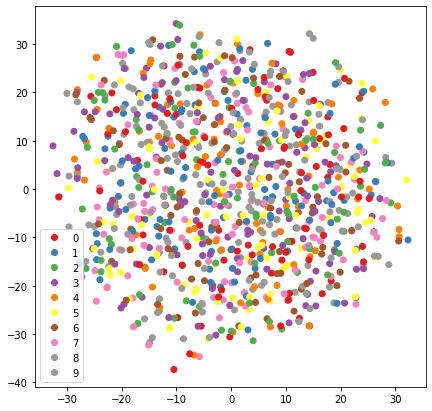

In [10]:
model_VAE, logs_VAE = train_VAE(kl_weight=1)
report(model_VAE, logs_VAE)

## VAE kl weight 1e-3
- Interpolates nicely but to the wrong reconstruction

Test Reconstruction Error: 0.0208: 100%|██████████| 20/20 [03:13<00:00,  9.65s/it]


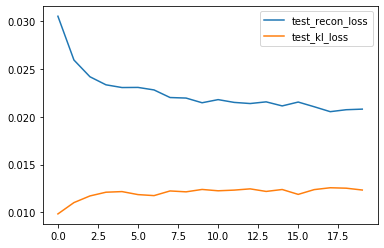

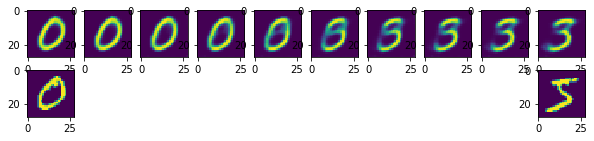

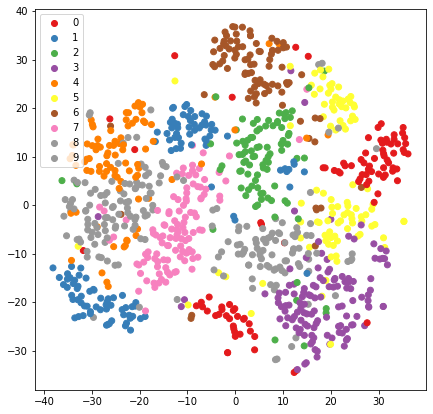

In [11]:
model_VAE, logs_VAE = train_VAE(kl_weight=1e-3)
report(model_VAE, logs_VAE)

## VAE kl weight 1e-4
- Interpolates nicely and even gets a bonus class in the middle

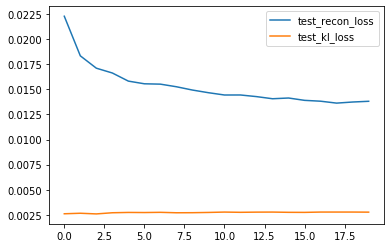

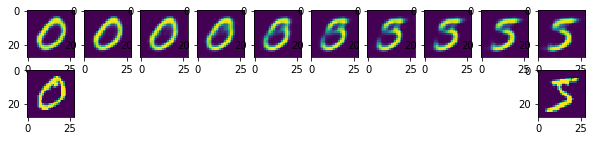

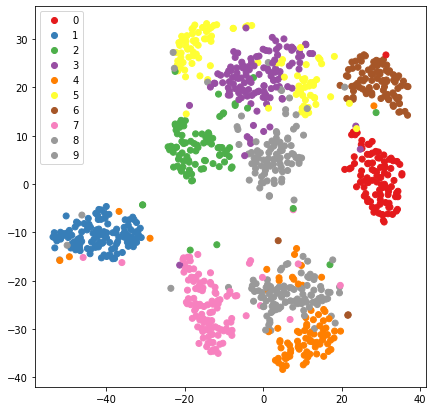

In [16]:
model_VAE, logs_VAE = train_VAE(kl_weight=1e-4)
report(model_VAE, logs_VAE)

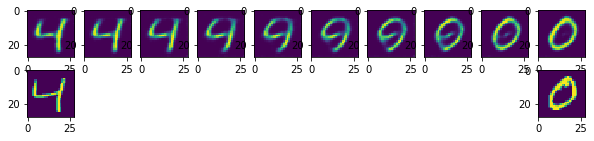

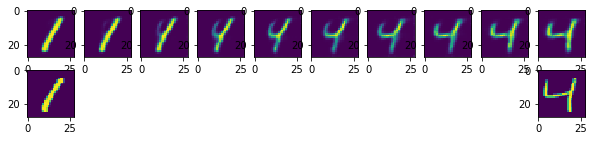

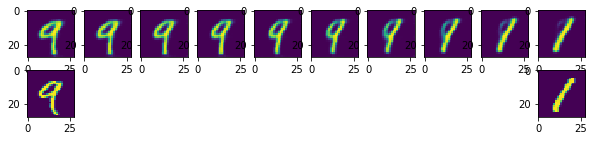

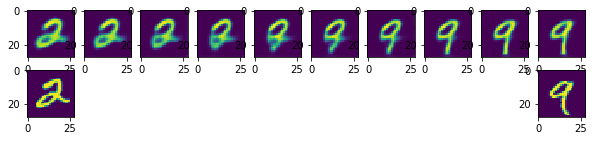

In [17]:
interpolate(model_VAE, 1, 2)
interpolate(model_VAE, 2, 3)
interpolate(model_VAE, 3, 4)
interpolate(model_VAE, 4, 5)

# Conclusion
- AE can reconstruct perfectly but interpolation produces unrealistic samples
- VAE induces a geometry in the embedded space having classes in between other classes
- Interpolating in embedded space produces more realistic transitions between samples, transitioning through a related 3rd class even
- VAE difficult to train as the KL weight hyperparam is very sensitive
- VAE sampling from distribution is very similar to adding noise in latent space or even mixup. All with the purpose of smoothing the space.
- KL loss forces representations to be very similar, even indistinguishable if the loss weight is too high. If used in right amount produces this geometry.